# 04f - Vertex AI > Training > Custom Jobs - Forecasting with Prophet using Custom Container

In this notebook and open-source solution named [Prophet](https://github.com/facebook/prophet) is utlized for custom forecasting.  Prophet is built on [Stan](https://mc-stan.org/), a probabalistic programming language, and has been implemented in Python and R.  Prophet is built to be robust to outliers and missing data while also being customizable where you can add domain knowledge about the forecasting.  It also offers automated visualizations, including interactive plots using [Plotly](https://plotly.com/graphing-libraries/).  Results are written back to BigQuery using [Pandas gbq](https://github.com/googleapis/python-bigquery-pandas) for further processing in BigQuery.

This notebook demonstrates how to progress from the experimental nature of a notebook based program, like `04e`, to an easy custom application built in a container.  The advantage is that the custom container can them be used as a Vertex AI Training job were it runs as a managed service any time you need to refit the forecast to new or different data.

### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery
- 04e - Vertex AI > Notebooks - Forecasting with Prophet (Python) - not required but worth reviewing as the code used here was developed in this notebook

### Overview:
- Setup
- Training
    - Assemble Python File for Training
    - Create Custom Container
        - Choose Base Image
        - Create Dockerfile
        - Setup Artifact Registry
            - Enable Artifact Registry API
            - Create A Repository
            - Configure Local Docker to Use GCLOUD CLI
        - Build the Custom Container (local to notebook)
        - Test the Custom Container (local to notebook)
        - Push the Custom Container to Artifact Registry
    - Setup Training Job
    - Run Training Job
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data
    - Visualize the Time Series with Forecast

### Resources:
- [Vertex AI Custom Container For Training](https://cloud.google.com/vertex-ai/docs/training/containers-overview)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04f_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04f_console.png">

---
## Setup

inputs:

In [2]:
PROJECT_ID='ma-mx-presales-lab'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04f'

BASE_IMAGE = 'gcr.io/deeplearning-platform-release/base-cpu'
TRAIN_COMPUTE = 'n1-standard-8'

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
from datetime import datetime
import json

clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = 'vertex-ai-mlops-bucket'
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [6]:
# Give service account roles/storage.objectAdmin permissions
# Console > IMA > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'825075454589-compute@developer.gserviceaccount.com'

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Training

### Assemble Python File for Training

Create the main python trainer file as `/train.py`:

In [8]:
!mkdir -p {DIR}/model/fit

In [9]:
%%writefile  {DIR}/model/fit/prophet.py
from prophet import Prophet
from google.cloud import bigquery
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import argparse

# import parameters
parser = argparse.ArgumentParser()
parser.add_argument('--PROJECT_ID', dest = 'PROJECT_ID', type = str)
parser.add_argument('--DATANAME', dest = 'DATANAME', type = str)
parser.add_argument('--NOTEBOOK', dest = 'NOTEBOOK', type = str)
parser.add_argument('--horizon', type=int)

parser.add_argument('--yearly', action='store_true')
parser.add_argument('--no-yearly', action='store_false')
parser.set_defaults(yearly=False)

args = parser.parse_args()
PROJECT_ID = args.PROJECT_ID
DATANAME = args.DATANAME
NOTEBOOK = args.NOTEBOOK
print(PROJECT_ID, DATANAME, NOTEBOOK)

# client for BQ
bigquery = bigquery.Client(project = PROJECT_ID)

# input data - from BQ
query = f"SELECT * FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped` ORDER by start_station_name, date"
source = bigquery.query(query = query).to_dataframe()

# preprocess data - as a list of dataframes for each series
seriesNames = source['start_station_name'].unique().tolist()
seriesFrames = []
for s in seriesNames:
    frame = source[(source['start_station_name']==s) & (source['splits']!='TEST')][['date','num_trips']].rename(columns={'date':'ds','num_trips':'y'})
    seriesFrames.append(frame)

# function to run a prophet fit & forecast
def run_prophet(series):
    if args.yearly:
        p = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    else:
        p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = 2* args.horizon)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

# run the series in a thread pool for multiprocessing
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

# postprocess data - add series name back to dataframe and concatenate all into one dataframe
for i, p in enumerate(predictions):
    p['start_station_name'] = seriesNames[i]
output = pd.concat(predictions)

# output data - to BQ
output.to_gbq(f"{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet", f'{PROJECT_ID}', if_exists = 'replace')

# Transform final data in BQ - merge with original input
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
    ),
    PROPHET AS (
        SELECT start_station_name, DATE(ds) as date, yhat, yhat_lower, yhat_upper
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
    )
SELECT *
FROM PROPHET
LEFT OUTER JOIN SOURCE
USING (start_station_name, date)
ORDER by start_station_name, date
"""
Tjob = bigquery.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

Writing temp/04f/model/fit/prophet.py


### Create Custom Container
- https://cloud.google.com/vertex-ai/docs/training/create-custom-container
- https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
- https://cloud.google.com/vertex-ai/docs/general/deep-learning
    - https://cloud.google.com/deep-learning-containers/docs/choosing-container

#### Choose a Base Image

In [10]:
BASE_IMAGE # Defined above in Setup

'gcr.io/deeplearning-platform-release/base-cpu'

#### Create the Dockerfile
A basic dockerfile thats take the base image and copies the code in and define an entrypoint - what python script to run first in this case.  Add RUN entries to pip install additional packages.

In [11]:
dockerfile = f"""
FROM {BASE_IMAGE}
WORKDIR /
RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
## Copies the trainer code to the docker image
COPY fit /fit
## Sets up the entry point to invoke the trainer
ENTRYPOINT ["python", "-m", "fit.prophet"]
"""
with open(f'{DIR}/model/Dockerfile', 'w') as f:
    f.write(dockerfile)

#### Setup Artifact Registry

The container will need to be stored in Artifact Registry, Container Registry or Docker Hub in order to be used by Vertex AI Training jobs.  This notebook will setup Artifact registry and push a local (to this notebook) built container to it. 

https://cloud.google.com/artifact-registry/docs/docker/store-docker-container-images#gcloud

##### Enable Artifact Registry API:
Check to see if the api is enabled, if not then enable it:

In [12]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: ma-mx-presales-lab


##### Create A Repository
Check to see if the registry is already created, if not then create it

In [13]:
repositories = !gcloud artifacts repositories list --format="json" --filter=REPOSITORY:{PROJECT_ID}
repositories = json.loads("".join(repositories[2:]))

if len(repositories) > 0:
    print(f'There is already a repository named {PROJECT_ID}')
else:
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"

There is already a repository named ma-mx-presales-lab


##### Configure Local Docker to Use GCLOUD CLI

In [14]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


To take a quick anonymous survey, run:
  $ gcloud survey



#### Build The Custom Container (local to notebook)

In [15]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}_{DATANAME}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/ma-mx-presales-lab/ma-mx-presales-lab/04f_citibikes:latest'

In [16]:
!docker build {DIR}/model/. -t $IMAGE_URI

Sending build context to Docker daemon  6.144kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/base-cpu
latest: Pulling from deeplearning-platform-release/base-cpu

88808835: Already exists 
cf64a9ea: Already exists 
c2aa40d3: Already exists 
2e264020: Already exists 
b700ef54: Already exists 
65f0ab42: Already exists 
ad4dbd7d: Already exists 
609522d8: Already exists 
2168e631: Already exists 
bb01bc78: Already exists 
da654f5c: Already exists 
40a4f176: Already exists 
eec75c0c: Already exists 
728eb7d7: Already exists 
30f752a4: Already exists 
5f7af5b1: Already exists 
b2dca45b: Pulling fs layer 
Digest: sha256:5290a56a15cebd867722be8bdfd859ef959ffd14f85979a9fbd80c5c2760c3a1[2A
Status: Downloaded newer image for gcr.io/deeplearning-platform-release/base-cpu:latest
 ---> 0db22ebb67a2
Step 2/5 : WORKDIR /
 ---> Running in dec70476600b
Removing intermediate container dec70476600b
 ---> 1799a5124b18
Step 3/5 : RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-clo

#### Test The Custom Container (local to notebook)

In [17]:
!docker run {IMAGE_URI} --PROJECT_ID {PROJECT_ID} --DATANAME {DATANAME} --NOTEBOOK {NOTEBOOK} --horizon {14} --no-yearly

Importing plotly failed. Interactive plots will not work.
ma-mx-presales-lab citibikes 04f
  0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.

Initial log joint probability = -52.3937

Initial log joint probability = -42.3717
Iterat

#### Push The Custom Container To Artifact Registry

In [18]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/ma-mx-presales-lab/ma-mx-presales-lab/04f_citibikes]

6a26a400: Preparing 
0c23b85d: Preparing 
dd2b9e38: Preparing 
e29d8d24: Preparing 
95a574c8: Preparing 
10151b48: Preparing 
c089358e: Preparing 
9b36546a: Preparing 
82ce8d0b: Preparing 
467ac3a5: Preparing 
91c31559: Preparing 
ae11254c: Preparing 
2bcbe281: Preparing 
4c112e39: Preparing 
048fd290: Preparing 
bf18a086: Preparing 
7a45d8d8: Preparing 
6651fb01: Preparing 
d5cafaa0: Preparing 
29d8d24: Pushed   1.897GB/1.816GBlatest: digest: sha256:2ab1aea1877a70f34229d15f5cf93f1ad9f17b5b2373de2f28dd275949ab7963 size: 4501


### Setup Training Job

In [19]:
CMDARGS = [
    "--PROJECT_ID=" + PROJECT_ID,
    "--DATANAME=" + DATANAME,
    "--NOTEBOOK=" + NOTEBOOK,
    "--horizon=" + '14',
    "--no-yearly"
]

MACHINE_SPEC = {
    "machine_type": TRAIN_COMPUTE,
    "accelerator_count": 0
}

WORKER_POOL_SPEC = [
    {
        "replica_count": 1,
        "machine_spec": MACHINE_SPEC,
        "container_spec": {
            "image_uri": IMAGE_URI,
            "command": [],
            "args": CMDARGS
        }
    }
]

In [20]:
customJob = aiplatform.CustomJob(
    display_name = f'{NOTEBOOK}_{DATANAME}',
    worker_pool_specs = WORKER_POOL_SPEC,
    base_output_dir = f"{URI}/{TIMESTAMP}",
    staging_bucket = f"{URI}/{TIMESTAMP}",
    labels = {'notebook':f'{NOTEBOOK}', 'yearly':'false'}
)

### Run Training Job

In [21]:
customJob.run(
    service_account = SERVICE_ACCOUNT,
    sync = False
)

INFO:google.cloud.aiplatform.jobs:Creating CustomJob


In [23]:
customJob.display_name

'04f_citibikes'

## Results

### Retrieve Test Data

In [25]:
query = f"""
SELECT
    date, 
    num_trips, 
    splits, 
    start_station_name, 
    yhat as predicted_num_trips
FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
WHERE splits = 'TEST'
"""
prophet = bigquery.query(query = query).to_dataframe()
prophet

,date,num_trips,splits,start_station_name,predicted_num_trips
0,2016-09-17,269,TEST,Central Park North & Adam Clayton Powell Blvd,242.627825
1,2016-09-18,272,TEST,Central Park North & Adam Clayton Powell Blvd,296.627032
2,2016-09-19,39,TEST,Central Park North & Adam Clayton Powell Blvd,162.764937
3,2016-09-20,120,TEST,Central Park North & Adam Clayton Powell Blvd,145.629066
4,2016-09-21,164,TEST,Central Park North & Adam Clayton Powell Blvd,146.129021
...,...,...,...,...,...
154,2016-09-26,102,TEST,W 82 St & Central Park West,74.414211
155,2016-09-27,105,TEST,W 82 St & Central Park West,73.941348
156,2016-09-28,72,TEST,W 82 St & Central Park West,77.712937
157,2016-09-29,143,TEST,W 82 St & Central Park West,74.787015


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [26]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM FORECASTS    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE,n
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.783951,48.905784,0.315086,14
1,Central Park S & 6 Ave,forecast,0.475135,93.055391,0.285134,14
2,Central Park W & W 96 St,forecast,0.463691,25.280127,0.252621,14
3,Central Park West & W 100 St,forecast,0.718590,14.844416,0.374454,14
4,Central Park West & W 102 St,forecast,0.466372,11.348224,0.224083,14
5,Central Park West & W 68 St,forecast,0.553865,49.978892,0.329894,14
6,Central Park West & W 72 St,forecast,0.667919,48.061491,0.271652,13
7,Central Park West & W 76 St,forecast,0.407398,29.128425,0.266013,14
8,Central Park West & W 85 St,forecast,1.043599,48.044094,0.382169,7
9,Grand Army Plaza & Central Park S,forecast,0.421556,44.492155,0.204598,13


Overall Metrics:

In [27]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM FORECASTS    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type     
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,n
0,forecast,0.533187,37.851246,0.282618,159


### Retrieve the Forecasting Data

In [28]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
ORDER by start_station_name, date
"""
prophet = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [29]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

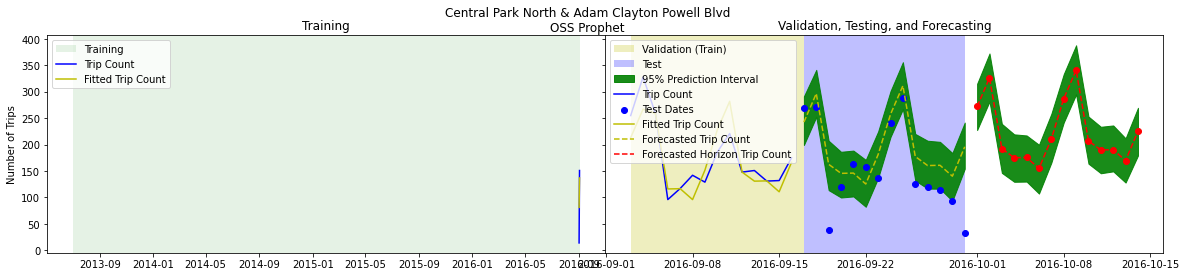

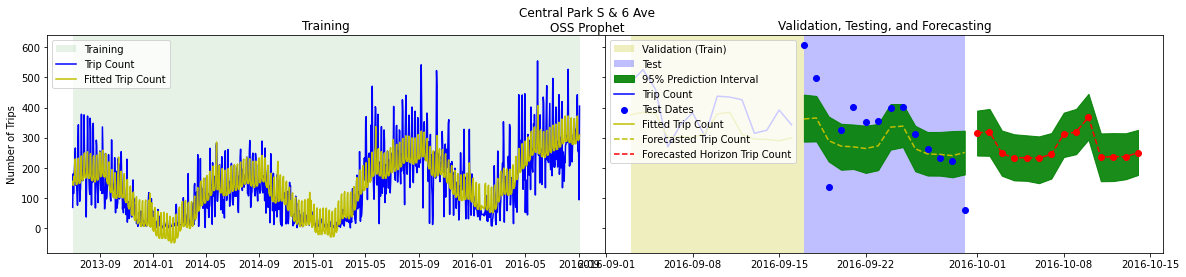

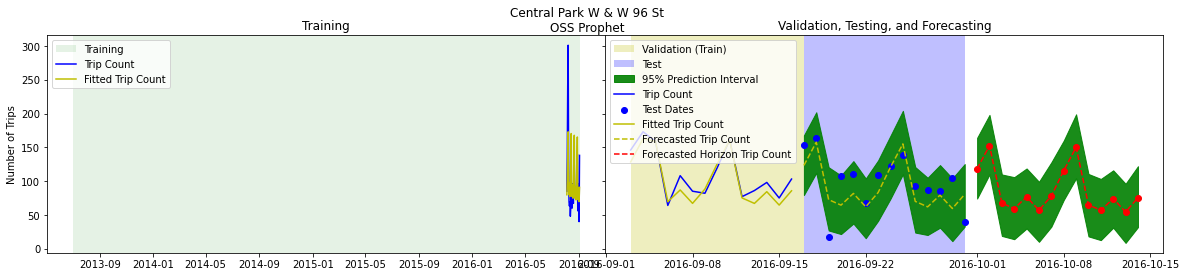

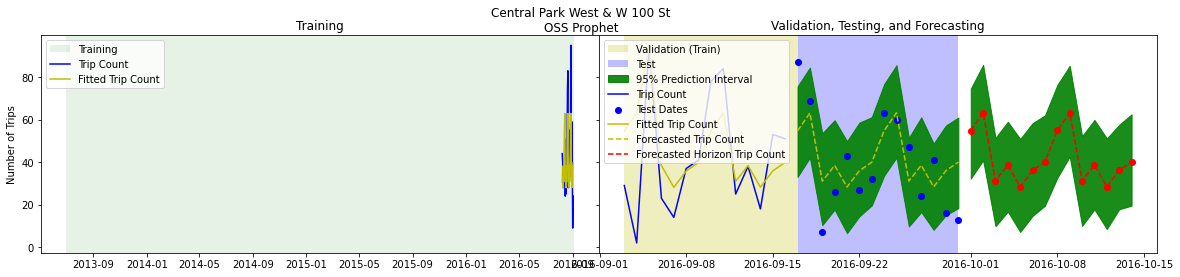

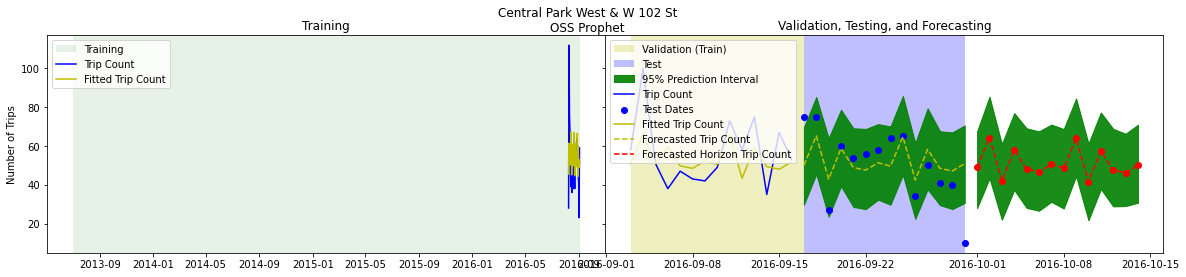

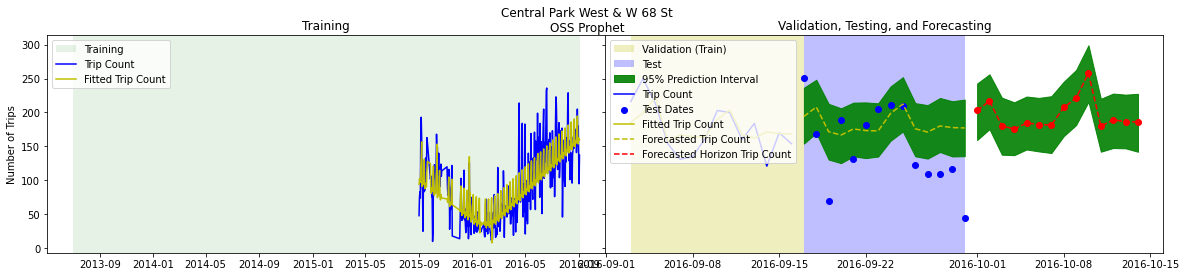

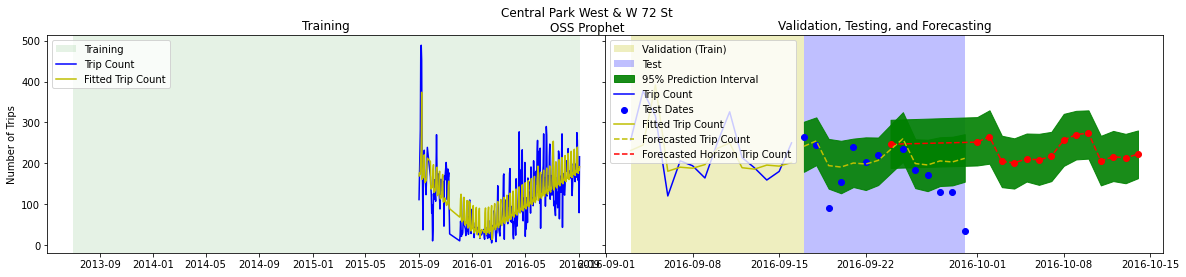

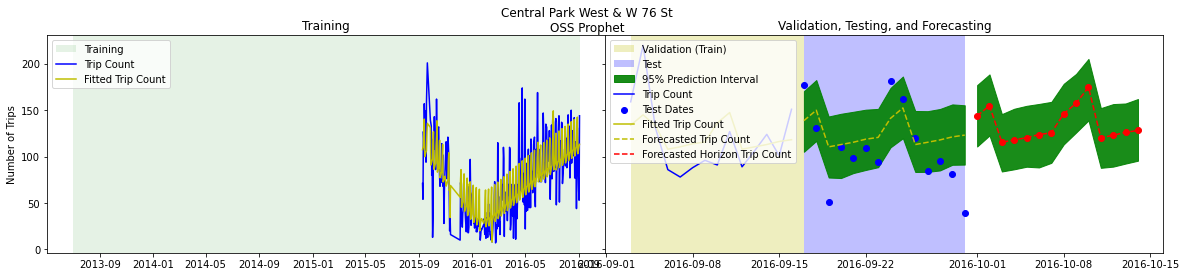

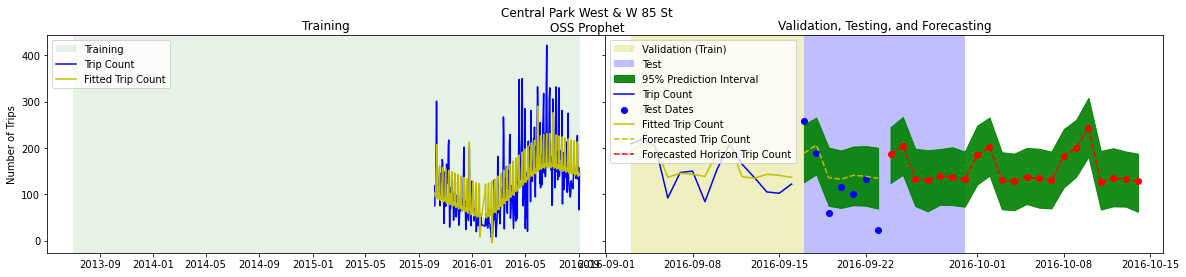

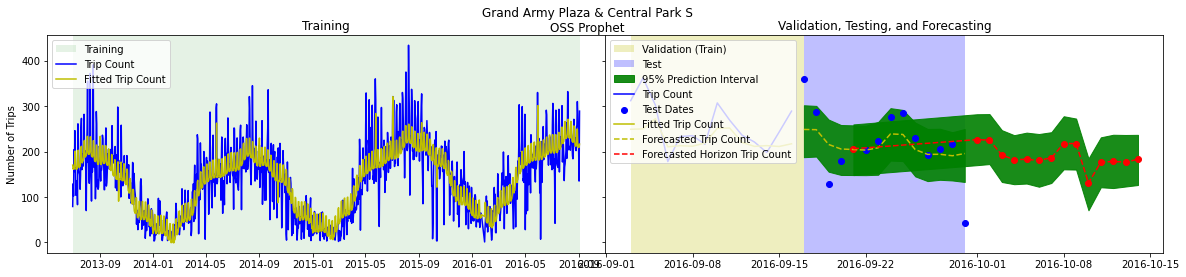

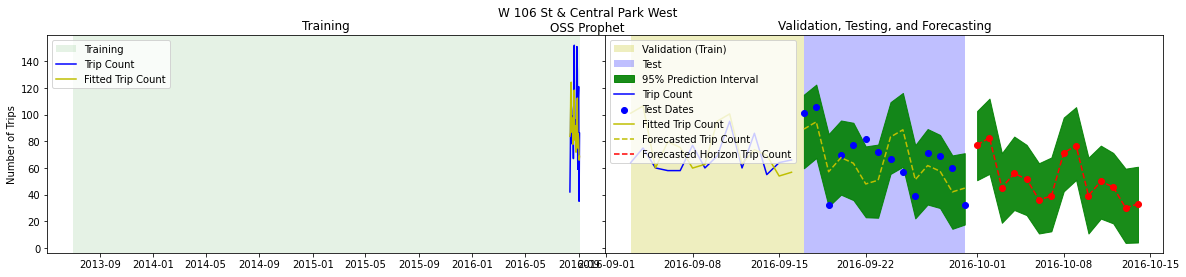

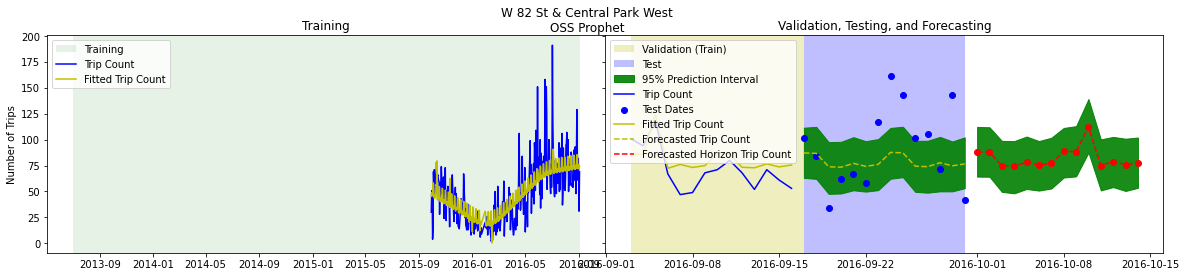

In [30]:
stations = prophet['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TRAIN')]
    valdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'VALIDATE')]
    testdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TEST')]
    horizondf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'].isna())]
    #fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(testdf['date'], testdf['yhat_lower'], testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].fill_between(horizondf['date'], horizondf['yhat_lower'], horizondf['yhat_upper'], color = 'g', alpha = 0.9)
    
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    axes[1].scatter(horizondf['date'], horizondf['yhat'], color = 'r')
    
    axes[0].plot(traindf['date'], traindf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(valdf['date'], valdf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(testdf['date'], testdf['yhat'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].plot(horizondf['date'], horizondf['yhat'], color = 'r', label = 'Forecasted Horizon Trip Count', linestyle='dashed')
    #axes[1].scatter(testdf['date'], testdf['yhat'], color = 'y')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nOSS Prophet")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"